# Installation des dependances

In [2]:
!pip install datasets[audio]
!pip install evaluate
!pip install jiwer
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.7 MB/s eta 0:00:00


# Chargement du dataset

Connection a huggingface pour charger le dataset

In [3]:
from huggingface_hub import notebook_login
notebook_login()

chargement des metadonnees

In [3]:
from datasets import load_dataset
from huggingface_hub import hf_hub_download
import os
import subprocess

dataset = load_dataset(
    "DigitalUmuganda/ASR_Fellowship_Challenge_Dataset",
    data_files={
        "train": ["train_tarred/sharded_manifests_with_image/manifest_0.json"],
        "validation": f"val_tarred/sharded_manifests_with_image/manifest_*.json",
        "test": f"val_tarred/sharded_manifests_with_image/manifest_*.json"
        },
)
media_dir = "/content/fellowship/data"

manifest_0.json: 0.00B [00:00, ?B/s]

manifest_0.json: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id'],
        num_rows: 6532
    })
    validation: Dataset({
        features: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id'],
        num_rows: 1617
    })
    test: Dataset({
        features: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id'],
        num_rows: 1617
    })
})

Chargement des fichiers audios

In [6]:

files_list = [
    "train_tarred/sharded_manifests_with_image/audio_shards/audio_0.tar.xz",
    "val_tarred/sharded_manifests_with_image/audio_shards/audio_0.tar.xz",
    "test_tarred/sharded_manifests_with_image/audio_shards/audio_0.tar.xz",
]

for f in files_list:

    os.makedirs(media_dir, exist_ok=True)

    file_path = hf_hub_download(
        repo_id="DigitalUmuganda/ASR_Fellowship_Challenge_Dataset",
        filename=f,
        repo_type="dataset"
    )

    subprocess.run(
        ["tar", "-xJf", file_path, "-C", media_dir],
        check=True
    )

print("Audio files downloaded and extracted successfully")

train_tarred/sharded_manifests_with_imag(…):   0%|          | 0.00/2.07G [00:00<?, ?B/s]

val_tarred/sharded_manifests_with_image/(…):   0%|          | 0.00/416M [00:00<?, ?B/s]

test_tarred/sharded_manifests_with_image(…):   0%|          | 0.00/522M [00:00<?, ?B/s]

Audio files downloaded and extracted successfully


Dimunition des donnees pour le test afin de faciliter l'entrainement

In [5]:
dataset_train = dataset["train"].select(range(1000))
dataset_val = dataset["validation"].select(range(300))
dataset_test = dataset["test"].select(range(60))
dataset_train = dataset_train.remove_columns(["recorder_id","project","image_filepath", "transcriber_id","LUFS","gender","age_group","location","image_shard_id"])
dataset_val = dataset_val.remove_columns(["recorder_id","project","image_filepath", "transcriber_id","LUFS","gender","age_group","location","image_shard_id"])
dataset_test = dataset_test.remove_columns(["recorder_id","project","image_filepath", "transcriber_id","LUFS","gender","age_group","location","image_shard_id"])


pretraitement de l'audio

In [7]:
import os
import librosa

def load_resample_audio(example):
  audio_path = os.path.join(media_dir,example["audio_filepath"])
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
  example["audio"]=audio_array
  return example


In [8]:
dataset_val = dataset_val.map(load_resample_audio)
dataset_test= dataset_test.map(load_resample_audio)
dataset_train = dataset_train.map(load_resample_audio)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3703926815.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000,mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset,

## Verify

In [9]:
from IPython.display import Audio

Audio(dataset_test[5]["audio"],rate=16000, autoplay=False)

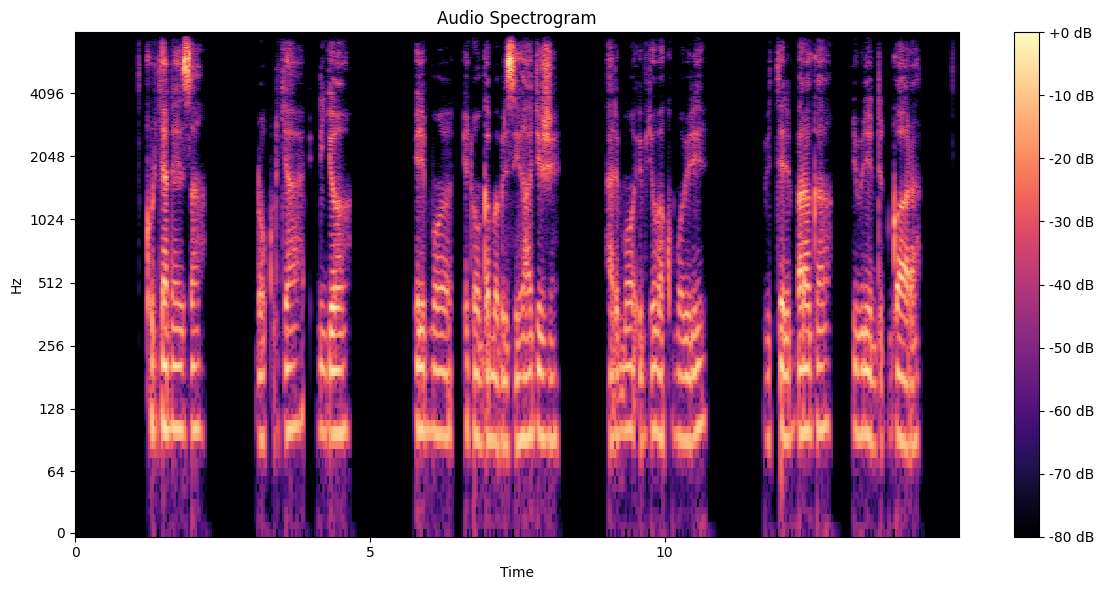

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_basic_spectrogram(audio_array, sr=16000, title="Spectrogram"):
    """
    Plot a basic spectrogram from audio array.

    Args:
        audio_array: 1D numpy array of audio
        sr: Sample rate (default 16000 for MMS)
        title: Plot title
    """
    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(audio_array)

    # Convert to decibels (log amplitude)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Plot
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage
plot_basic_spectrogram(np.asarray(dataset_test[5]["audio"]), sr=16000, title="Audio Spectrogram")

# Get metrics for initial model

In [11]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Define the language code for Kinyarwanda (ISO 639-3 code 'kin')
language_id = "kin"


In [12]:
# Load the MMS model with the pre-trained Kinyarwanda adapter
model_name = "facebook/mms-1b-all"
initial_processor = Wav2Vec2Processor.from_pretrained(model_name)
initial_model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Set the language adapter for Kinyarwanda
initial_processor.tokenizer.set_target_lang(language_id)
initial_model.load_adapter(language_id)

preprocessor_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

adapter.kin.safetensors:   0%|          | 0.00/9.36M [00:00<?, ?B/s]

In [13]:
# Process the audio and run inference
def transcriber_audio(audio):
  inputs = initial_processor(audio, sampling_rate=16000, return_tensors="pt")
  with torch.no_grad():
      logits = initial_model(**inputs).logits

  # Get the predicted token IDs and decode to text
  predicted_ids = torch.argmax(logits, dim=-1)
  initial_transcription = initial_processor.batch_decode(predicted_ids)[0]

  return initial_transcription

check transcription

In [14]:
transcriber_audio(dataset_test[5]["audio"])

"kurya neza nukurya nyo irimo intungamubiri zihagije harimo ibyuba kumubiri bitera imbaraga n'ibirindi ndwara"

In [15]:
print(f"Original : {dataset_test[5]["text"]}")

Original : kurya neza ni ukurya indyo irimo intungamubiri zihagije harimo ibyubaka umubiri ibitera imbaraga n'ibirinda indwara


Calculate inital WER

In [16]:
from datasets import Dataset
from jiwer import wer
import pandas as pd
import numpy as np

def calculate_sample_wer(example):
    reference = str(example['text'])
    hypothesis = transcriber_audio(example['audio'])

    # Calculate WER
    example['wer'] = wer(reference, hypothesis)
    example["prediction"] = hypothesis

    return example

In [ ]:
# Apply map function to calculate WER for all samples
temp_dataset = dataset_test.map(
    calculate_sample_wer,
    desc="Calculating initial WER"
)

Calculating initial WER:   0%|          | 0/100 [00:00<?, ? examples/s]

In [34]:
temp_dataset_with_wer = temp_dataset.to_pandas()

# Calculate overall statistics
overall_wer = wer(
    temp_dataset_with_wer['text'].tolist(),
    temp_dataset_with_wer['prediction'].tolist()
)

print(f"Overall WER: {overall_wer:.2%}")

Overall WER: 29.70%


# Partie 2: Modele finetunne

parametres du modele

In [19]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", target_lang=language_id)
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [20]:
def prepare_dataset(batch):

    # batched output is "un-batched"
    batch["input_values"] = processor(batch["audio"], sampling_rate=16000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    batch["labels"] = processor(text=batch["text"]).input_ids
    return batch


In [ ]:
# if you want to save data
dataset_train.save_to_disk("dataset_train_tarred")
dataset_val.save_to_disk("dataset_val_tarred")
dataset_test.save_to_disk("dataset_test_tarred")

Saving the dataset (0/3 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [13]:
# if you want to load saved data
from datasets import load_from_disk
dataset_test=load_from_disk("/content/drive/MyDrive/Test/dataset_test_tarred")
dataset_val=load_from_disk("/content/drive/MyDrive/Test/dataset_val_tarred")
dataset_train=load_from_disk("/content/drive/MyDrive/Test/dataset_train_tarred")


In [21]:
from IPython.display import Audio

Audio(dataset_test[5]["audio"],rate=16000, autoplay=False)

In [16]:
new_dataset_train = dataset_train.map(prepare_dataset, remove_columns=dataset_train.column_names)
new_dataset_val = dataset_val.map(prepare_dataset, remove_columns=dataset_val.column_names)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [18]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        labels_batch = self.processor.pad(
            labels=label_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [19]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [20]:
from evaluate import load

wer_metric = load("wer")

In [21]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In [23]:
from transformers import Wav2Vec2ForCTC

new_model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/mms-1b-all",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
    ignore_mismatched_sizes=True,
)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/mms-1b-all and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([154]) in the checkpoint and torch.Size([32]) in the model instantiated
- lm_head.weight: found shape torch.Size([154, 1280]) in the checkpoint and torch.Size([32, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
new_model.init_adapter_layers()

In [25]:
new_model.freeze_base_model()

adapter_weights = new_model._get_adapters()
for param in adapter_weights.values():
    param.requires_grad = True

In [26]:
!pip install wandb
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [27]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_PROJECT"] = "fellowship"
os.environ["WANDB_NAME"] = "mms_finnetuned"


In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
   output_dir="checkpoints",
   group_by_length=True,
  per_device_train_batch_size=8,
  eval_strategy="steps",
  num_train_epochs=5,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=200,
  eval_steps=100,
  logging_steps=100,
  learning_rate=1e-3,
  warmup_steps=100,
  save_total_limit=2,
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [30]:
from transformers import Trainer

trainer = Trainer(
    model=new_model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=new_dataset_train,
    eval_dataset=new_dataset_val,
    tokenizer=processor.feature_extractor
)


/tmp/ipython-input-2074548549.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/backends/cudnn/__init__.py:145: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  torch._C._get_cudnn_allow_tf32(),


Step,Training Loss,Validation Loss,Wer
100,3.145200,0.166016,0.221815
200,0.191300,0.152365,0.204882
300,0.169900,0.148076,0.196034
400,0.157800,0.149295,0.198932
500,0.147200,0.141576,0.189321
600,0.135800,0.140375,0.186575


TrainOutput(global_step=625, training_loss=0.636849393081665, metrics={'train_runtime': 5316.0076, 'train_samples_per_second': 0.941, 'train_steps_per_second': 0.118, 'total_flos': 7.44340759728908e+18, 'train_loss': 0.636849393081665, 'epoch': 5.0})

In [32]:
eval_results = trainer.evaluate()
print(f"WER: {eval_results['eval_wer']:.2%}")

WER: 18.66%


enregistrement du model

In [33]:
from safetensors.torch import save_file as safe_save_file
from transformers.models.wav2vec2.modeling_wav2vec2 import WAV2VEC2_ADAPTER_SAFE_FILE
import os

adapter_file = WAV2VEC2_ADAPTER_SAFE_FILE.format(language_id)
adapter_file = os.path.join(training_args.output_dir, adapter_file)

safe_save_file(new_model._get_adapters(), adapter_file, metadata={"format": "pt"})


# Metrics et Rapports

finetuned model

In [24]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
language_id="kin"
# 1. Charger le modèle entraîné
model_dir = "/content/drive/MyDrive/Test/model/checkpoints/checkpoint-600"
fin_processor = Wav2Vec2Processor.from_pretrained(model_dir,target_lang="kin")
fin_model = Wav2Vec2ForCTC.from_pretrained(model_dir)

base model

In [25]:
# Process the audio and run inference
def transcriber(audio, pProc, pModel):
  inputs = pProc(audio, sampling_rate=16000, return_tensors="pt",  padding=True)
  with torch.no_grad():
      logits = pModel(**inputs).logits

  # Get the predicted token IDs and decode to text
  predicted_ids = torch.argmax(logits, dim=-1)
  transcript = pProc.batch_decode(predicted_ids)[0]
  clean_text = transcript.replace("[PAD]", "").replace("  ", " ").strip()


  return clean_text

Test on single element

In [75]:
print(f"Original Transcription: {dataset_test[5]["text"]}")
print(f"Base model Transcription: {transcriber(dataset_test[5]["audio"],initial_processor, initial_model)} ")
print(f"Finetuned model Transcription: {transcriber(dataset_test[5]["audio"],fin_processor, fin_model)} ")

Original Transcription: kurya neza ni ukurya indyo irimo intungamubiri zihagije harimo ibyubaka umubiri ibitera imbaraga n'ibirinda indwara
Base model Transcription: kurya neza nukurya nyo irimo intungamubiri zihagije harimo ibyuba kumubiri bitera imbaraga n'ibirindi ndwara 
Finetuned model Transcription: kurya neza ni ukurya nyo irimo intungamubiri zihagije harimo ibyuba kaumubiri ibitera imbaraga n'ibirindi ndwara 


In [26]:
from datasets import Dataset
from jiwer import wer
import pandas as pd
import numpy as np

def calculate_wer(example):
    reference = str(example['text'])
    finetuned_transcription = transcriber(example['audio'],fin_processor, fin_model)
    # Calculate WER
    example["finetuned_transcription"] = finetuned_transcription
    example["prediction"] = transcriber(example['audio'],initial_processor, initial_model)

    return example

In [29]:
# Apply map function to calculate WER for all samples
temp_dataset = dataset_test.map(
    calculate_wer,
    desc="Calculating WER"
)

Calculating WER:   0%|          | 0/60 [00:00<?, ? examples/s]

In [31]:
temp_dataset_wer = temp_dataset.to_pandas()

finetuned_overall_wer = wer(
    temp_dataset_wer['text'].tolist(),
    temp_dataset_wer['finetuned_transcription'].tolist()
)

print(f"Finetuned Overall WER: {finetuned_overall_wer:.2%}")

Finetuned Overall WER: 24.46%


finetuned trascript txt

In [32]:
with open("original_transcriptions.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(temp_dataset_wer["text"].tolist()))

In [ ]:
with open("finetuned_transcriptions.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(temp_dataset_wer["finetuned_transcription"].tolist()))

In [ ]:
with open("base_transcriptions.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(temp_dataset_wer["prediction"].tolist()))